In [1]:
import torch
import torch.nn as nn 
from torchvision import datasets,transforms
from torch.utils.data import DataLoader , random_split

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224


In [3]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3,std=[0.5]*3)
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3,std=[0.5]*3)
    ]
)

In [4]:
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transforms)
val_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=val_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [6]:
##here the images are given in the shape B,channels,height,width
class PatchEmbeddings(nn.Module):
    def __init__(self,num_channels = 3,
                 patch_size = 16,
                 embedding_dim = 768):
        super().__init__()

        self.patch_size = patch_size
        self.patched_embeddings = nn.Conv2d(in_channels= num_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten_embeddings= nn.Flatten(2,3)

                                            
    def forward(self,x):
        image_resolution = x.shape[-1] #used to check the comaptability with the patch size 
        assert image_resolution % self.patch_size == 0

        x_patched = self.patched_embeddings(x)
        x_flatten = self.flatten_embeddings(x_patched) #shape->(batch,768,4)

        return x_flatten.permute(0,2,1)


In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_heads = 12 ,
                 embedding_dim = 768,
                 attention_dropout = 0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.mha = nn.MultiheadAttention(embedding_dim,num_heads,attention_dropout,batch_first = True)
    def forward(self,x):
        x = self.layer_norm(x)
        context_vec,_= self.mha(key = x, value = x , query = x,need_weights = False) # the need wieghts is the attention score which we dont want

        return context_vec

In [8]:
class FFN(nn.Module):
    def __init__(self,in_embedding_dim = 768,
                 hidden_emb_size = 3072,
                 dropout = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(in_embedding_dim)

        self.ffn = nn.Sequential(
            nn.Linear(in_embedding_dim,hidden_emb_size,bias=False),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_emb_size,out_features=in_embedding_dim,bias=False),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        x = self.layer_norm(x)
        x = self.ffn(x)

        return x     

In [9]:
class encoder_block(nn.Module):
    def __init__(self, num_heads =12 , 
                 embedding_dim = 768,
                 drop_out = 0.1,
                 hidden_emb = 3072,
                 attn_drop = 0
                 ):
        super().__init__()

        self.mha_layer = MultiHeadAttention(embedding_dim=embedding_dim,num_heads=num_heads,attention_dropout=drop_out)
        self.ffn = FFN(in_embedding_dim=embedding_dim,hidden_emb_size=hidden_emb,dropout=drop_out)

    def forward(self,x):
        x = self.mha_layer(x) + x #residual connections
        x = self.ffn(x) + x ##residual connections

        return x    


In [10]:
class ViT(nn.Module):
    def __init__(self,
                 embedding_size = 768,
                 patch_size = 16,
                 num_heads = 12,
                 hidden_emb = 3072,
                 dropout = 0.1,
                 attn_dropout = 0,
                 image_height = 224,
                 image_Width = 224,
                 num_channels = 3,
                 classes = 1000,
                 pos_drop = 0.1,
                 num_block = 12

                 ):
        super().__init__()
        self.num_patches = image_height * image_Width // (patch_size * patch_size)
        self.patch_embedding =  PatchEmbeddings(patch_size=patch_size,embedding_dim=embedding_size,num_channels=3)
        self.positional_embedding = nn.Parameter(torch.rand(1,self.num_patches+1,embedding_size),requires_grad = True)
        self.cls_token = nn.Parameter(torch.rand(1,1,embedding_size),requires_grad = True)
        self.positional_drop_out = nn.Dropout(p = pos_drop)


        self.encoder_block = nn.Sequential(
            *[encoder_block(
                num_heads=num_heads,
                embedding_dim=embedding_size,
                hidden_emb=hidden_emb,
                drop_out=attn_dropout) for _ in range(num_block)]
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=embedding_size,
                      out_features=classes)
        )

    def forward(self,x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        cls_token = self.cls_token.expand(batch_size,-1,-1)#okay so here we first reate the cls token embedding to match our batch size so that it can be appended to evry data in the batch
        x = torch.cat((x,cls_token),dim=1)
        x = x + self.positional_embedding

        x = self.positional_drop_out(x)
        x =self.encoder_block(x)
        x = self.classifier(x[:,-1])

        return x 






In [11]:
model =  ViT(
    embedding_size=768,
    patch_size=16,
    num_block=12,
    num_channels=3,
    classes=10,
    
)

In [12]:
model

ViT(
  (patch_embedding): PatchEmbeddings(
    (patched_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten_embeddings): Flatten(start_dim=2, end_dim=3)
  )
  (positional_drop_out): Dropout(p=0.1, inplace=False)
  (encoder_block): Sequential(
    (0): encoder_block(
      (mha_layer): MultiHeadAttention(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (ffn): FFN(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=False)
          (1): GELU(approximate='none')
          (2): Dropout(p=0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=False)
          (4): Dropout(p=0, inplace=False)
        )
      )
    )
    (1): encoder_block(
  

In [13]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(),lr=4e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
from tqdm import tqdm

def train(model, train_loader, val_loader, calc_loss, optimizer, device, epochs=10):
    model.to(device)
    best_val_acc = 0.0
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()

        train_loss, train_correct, total = 0.0, 0, 0

        # Training loop with tqdm
        pbar = tqdm(train_loader, desc=f"Train Epoch {epoch+1}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = calc_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Log batch-level metrics (optional)
            pbar.set_postfix(loss=loss.item())

        train_acc = 100. * train_correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = calc_loss(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total
        val_loss /= val_total

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)


        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

       

        # Save best model
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

    print(f"\nTraining complete. Best Val Acc: {best_val_acc:.2f}%")


In [ ]:
train(model, train_loader, val_loader, loss, optimizer, device, epochs=10)

In [8]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [14]:
model = model.to(device='cpu')

In [19]:
checkpoint_path = "/Users/777bhavyagoyal/Developer/IMPLEMENTING-RESEARCH-PAPERS/ViT/model_epoch_5.pth"  

# Load the checkpoint with map_location set to 'cpu'
checkpoint = torch.load(checkpoint_path, map_location='cpu')

/var/folders/hp/y1d826dx5fb1405ppnjjm4700000gn/T/ipykernel_49625/203237139.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

In [20]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [21]:
import torch
from torchvision import transforms
from PIL import Image

# Ensure model is in evaluation mode
model.eval()

# Transform (use the same as during training!)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3,std=[0.5]*3)
])

# Load and preprocess image
def predict_image(img_path, class_names):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to('cpu')  # Or to 'cuda' if using GPU

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]
    print(f"🖼️ Image: {img_path} => Predicted Class: {predicted_class}")



In [22]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [112]:
image, label = val_dataset[140]
label

6

In [113]:
# Let's say your image tensor is named `image_tensor`
image_tensor = image.unsqueeze(0)  # Shape becomes [1, 3, H, W]


In [114]:
# Skip this if already on CPU
image_tensor = image_tensor.to('cpu')


In [115]:
model.eval()  # Evaluation mode

with torch.no_grad():
    output = model(image_tensor)
    predicted_class = torch.argmax(output, dim=1).item()


In [116]:
predicted_class

4

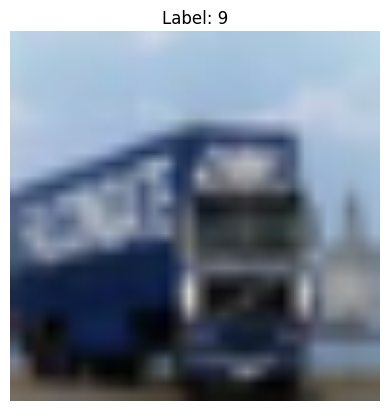

In [118]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

# Get one image from the dataset
image_tensor, label = val_dataset[3999]  # already transformed

# Unnormalize: convert from [-1, 1] back to [0, 1]
unnormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)
image_tensor = unnormalize(image_tensor)

# Convert to NumPy for plotting
image_np = image_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]

# Plot
plt.imshow(image_np)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
